# Libraries and stuff

In [2]:
!pip uninstall torchvision
!pip3 install numpy --pre torch torchvision torchaudio --force-reinstall --index-url https://download.pytorch.org/whl/nightly/cu118

^C


In [ ]:
!pip install torchmetrics

In [1]:
import torchvision

In [7]:
torchvision.__version__

'0.17.0.dev20231008+cu118'

In [8]:
import numpy as np
import pandas as pd
import json

In [9]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### for colab interface

In [6]:
project_path = "/content/drive/My Drive/samolet/urbanhack-train/"
images_path = "/content/drive/My Drive/samolet/urbanhack-train/images/"
annotations_path = "/content/drive/My Drive/samolet/urbanhack-train/annotations/instances_default.json"

### for local interface

In [13]:
project_path = "urbanhack-train/"
images_path = "urbanhack-train/images/"
annotations_path = "urbanhack-train/annotations/instances_default.json"

# some data research:

In [14]:
with open(annotations_path) as json_data:
    data = json.load(json_data)

In [15]:
data.keys()

dict_keys(['licenses', 'info', 'categories', 'images', 'annotations'])

In [16]:
df_images = pd.DataFrame(data['images'])
df_boxes = pd.DataFrame(data['annotations'])

In [17]:
data['categories']

[{'id': 1, 'name': 'window', 'supercategory': ''},
 {'id': 2, 'name': 'empty', 'supercategory': ''},
 {'id': 3, 'name': 'filled', 'supercategory': ''}]

In [18]:
df_images.head()

id  width  height               file_name  license flickr_url coco_url  \
0   1    854     572  0000019949building.jpg        0                       
1   2    881     720  0000019869building.jpg        0                       
2   3    847     544  0000019458building.jpg        0                       
3   4    303     600  0000019455building.jpg        0                       
4   5    869     676  0000019431building.jpg        0                       

   date_captured  
0              0  
1              0  
2              0  
3              0  
4              0

In [19]:
df_boxes['occluded'] = df_boxes['attributes'].apply(lambda x: x['occluded'])
df_boxes['rotation'] = df_boxes['attributes'].apply(lambda x: x['rotation'])

In [20]:
df_boxes.head()

id  image_id  category_id segmentation        area  \
0   1         1            2           []  12677.0917   
1   2         1            2           []  16279.1769   
2   3         1            2           []  13944.2534   
3   4         1            2           []  13847.1183   
4   5         1            2           []  10862.9570   

                               bbox  iscrowd  \
0   [98.87, 141.25, 110.63, 114.59]        0   
1  [723.17, 184.07, 130.83, 124.43]        0   
2    [475.7, 48.84, 116.62, 119.57]        0   
3   [593.81, 62.38, 118.89, 116.47]        0   
4      [0.0, 259.95, 81.34, 133.55]        0   

                             attributes  occluded  rotation  
0  {'occluded': False, 'rotation': 0.0}     False       0.0  
1  {'occluded': False, 'rotation': 0.0}     False       0.0  
2  {'occluded': False, 'rotation': 0.0}     False       0.0  
3  {'occluded': False, 'rotation': 0.0}     False       0.0  
4  {'occluded': False, 'rotation': 0.0}     False       0.0

In [21]:
df_boxes['category_id'].value_counts()

3    14228
1    12158
2    11945
Name: category_id, dtype: int64

In [22]:
images2n_categories = {}

for i in range(1,4):
    indices = (df_boxes.groupby('image_id')['category_id'].nunique()==i)
    images2n_categories[i] = indices.index[indices].tolist()

In [ ]:
images2n_categories

In [24]:
df_boxes.groupby('image_id')['bbox'].count().max()

551

In [ ]:
categories2images = {}

for i in range(1,4):
    indices = (df_boxes.groupby('category_id')['image_id'].nunique()==i)
    categories2images[i] = indices.index[indices].tolist()

In [ ]:
categories2images

{1: [], 2: [], 3: []}

(array([30., 27., 20., 18., 11., 12., 23.,  4., 22.,  1.,  1.,  2.,  0.,
         1.,  5.,  3.,  1.,  4.,  6., 61.]),
 array([ 247. ,  443.5,  640. ,  836.5, 1033. , 1229.5, 1426. , 1622.5,
        1819. , 2015.5, 2212. , 2408.5, 2605. , 2801.5, 2998. , 3194.5,
        3391. , 3587.5, 3784. , 3980.5, 4177. ]),
 <BarContainer object of 20 artists>)

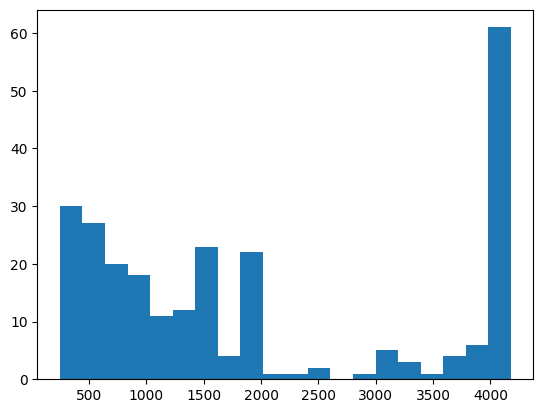

In [33]:
plt.hist(df_images['width'], bins=20)

# Making *torchvision* Dataset:

Подключаем библиотеки:

In [10]:
import os
import torch
import torchvision

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

Непосредственно класс датасета:

In [11]:
from dataset import SamoletDataset, collate_fn_padd

## testing

Тестовый DataLoader:

In [14]:
dataset = SamoletDataset(project_path)

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=5,
    #shuffle=True,
    collate_fn=collate_fn_padd
)

# For Training
batch = next(iter(data_loader))

Тестируем:

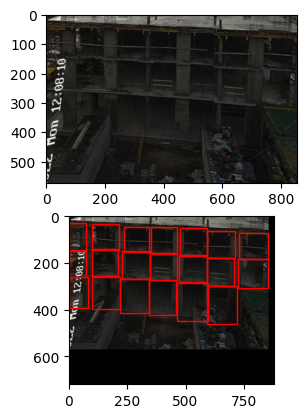

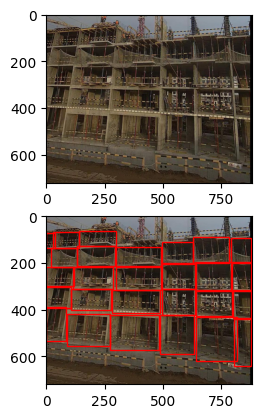

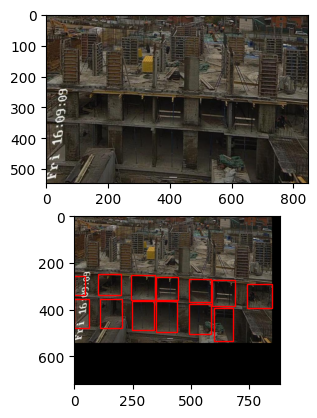

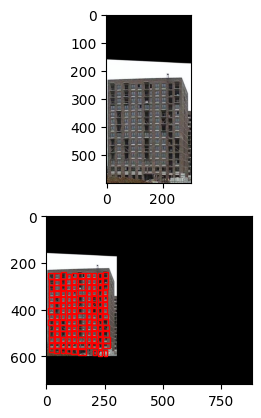

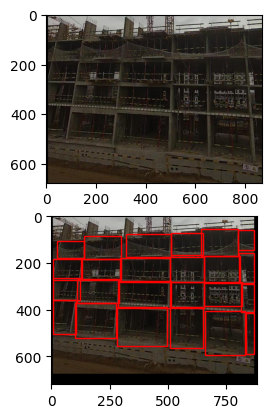

In [15]:
for i in range(5):
    fig, ax = plt.subplots(2)
    ax[0].imshow(dataset[i][0].permute(1, 2, 0))
    ax[1].imshow(batch[0][i].permute(1, 2, 0))

    # отрисовываем
    for bbox in batch[1][i]['boxes']:
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)
        #ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

# Augmentations:

In [6]:
from augmentation import get_transform

### Протестируем

In [16]:
dataset_aug = SamoletDataset(project_path, get_transform(train=True))

In [17]:
dataset = SamoletDataset(project_path)

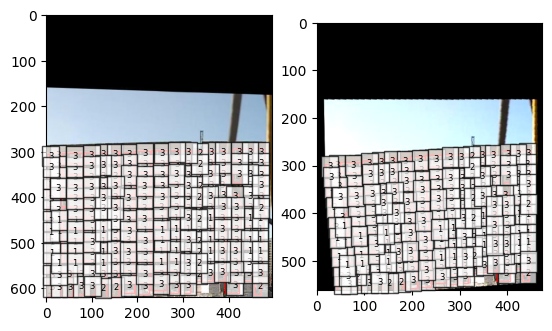

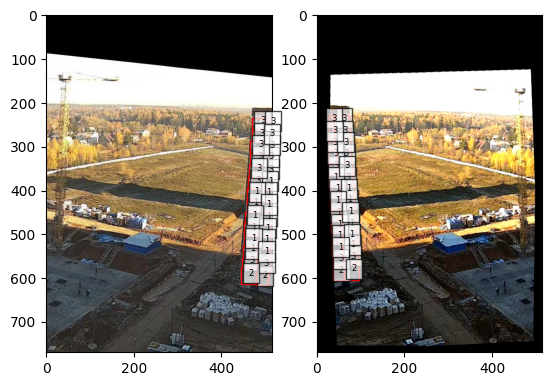

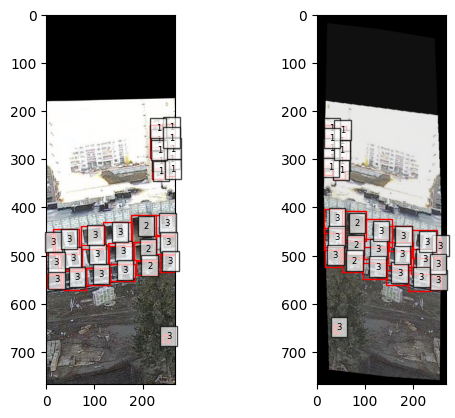

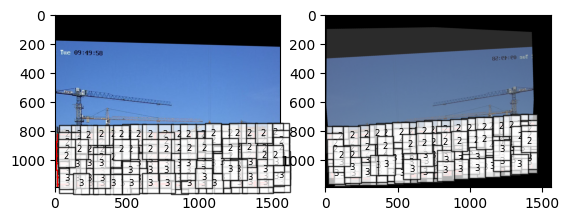

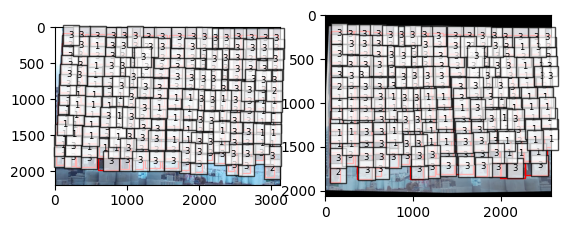

In [18]:
for i in range(5):
    fig, ax = plt.subplots(1, 2)

    img, target = dataset[i+10]
    img_aug, target_aug = dataset_aug[i+10]

    ax[0].imshow(img.permute(1, 2, 0))
    ax[1].imshow(img_aug.permute(1, 2, 0))

    for bbox, label in zip(target['boxes'], target['labels']):
        x1, y1, x2, y2 = bbox.cpu().detach().numpy()
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax[0].add_patch(rect)
        ax[0].text((x1+x2)/2, (y1+y2)/2, label.cpu().detach().numpy(), fontsize=6, bbox=dict(facecolor='white', alpha=0.7))

    for bbox, label in zip(target_aug['boxes'], target_aug['labels']):
        x1, y1, x2, y2 = bbox.cpu().detach().numpy()
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)
        ax[1].text((x1+x2)/2, (y1+y2)/2, label.cpu().detach().numpy(), fontsize=6, bbox=dict(facecolor='white', alpha=0.7))

# Transfer learning:

## If you use already trained model for this task, just run following cell without learning stage:

In [ ]:
model = torch.load('model.pth')

## Learning itself:

In [19]:
from engine import train_one_epoch

### model design

In [20]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator


# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT", trainable_backbone_layers=5)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 4  # 3 classes + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
#model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.box_detections_per_img = 1000
model.box_nms_thresh = 0.5

anchor_generator = AnchorGenerator(
    sizes=((16, 32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

model.rpn_anchor_generator=anchor_generator

### device selection

In [29]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### datasets and dataloaders

In [24]:
# use our dataset and defined transformations
dataset = SamoletDataset(project_path, get_transform(True))
dataset_test = SamoletDataset(project_path, get_transform(False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=5,
    shuffle=True,
    collate_fn=collate_fn_padd
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn_padd
)

### learning params

In [23]:
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

#optimizer = torch.optim.AdamW(params)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=10,
    gamma=0.1
)

### training

In [27]:
!nvidia-smi

Sun Oct  8 13:24:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    30W /  70W |  14205MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [30]:
from IPython.display import clear_output

# let's train it for 5 epochs
num_epochs = 20

train_loss = []
val_loss = []

for epoch in range(num_epochs):

    print('* Epoch %d/%d' % (epoch+1, num_epochs))
    t_l, v_l = train_one_epoch(model, optimizer, data_loader, data_loader_test, device, epoch, print_freq=10)
    train_loss.append(t_l)
    val_loss.append(v_l)

    # update the learning rate
    lr_scheduler.step()

    # visualize
    clear_output(wait=True)
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()


print("That's it!")

* Epoch 1/20


NameError: ignored

### saving model

In [26]:
torch.save(model, 'model.pth')

# Метрики

In [21]:
from torchmetrics.detection import MeanAveragePrecision

def eval_map50(model, x, target, device):
    metric = MeanAveragePrecision(iou_type="bbox")
    predictions = model(x.to(device))
    predictions_cpu = [{k:v.cpu().detach() for k,v in predictions[0].items()}]
    metric.update(predictions_cpu, target)
    metric_dict = metric.compute()

    return metric_dict['map_50']

In [31]:
# For inference
model.eval()
iterator = iter(data_loader_test)

map50_l = []

for i in range(25):
    x, target = next(iterator)
    map50_l.append(eval_map50(model, x, target, device).cpu().detach().numpy())

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [32]:
np.mean(map50_l)

0.49720633

# Evaluate:

In [33]:
%matplotlib inline

def plot_boxes(pic, gt_boxes, pred_boxes, gt_labels, pred_labels):
    fig, ax = plt.subplots(1, 2, figsize=(16, 10))

    ax[0].imshow(pic)
    ax[1].imshow(pic)

    # заголовки
    ax[0].set_title('ground truth boxes:')
    ax[1].set_title('predicted boxes:')

    # отрисовываем ground truth boxes
    for bbox, label in zip(gt_boxes, gt_labels):
        x1, y1, x2, y2 = bbox.cpu().detach().numpy()
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax[0].add_patch(rect)
        ax[0].text((x1+x2)/2, (y1+y2)/2, label.cpu().detach().numpy(), fontsize=6, bbox=dict(facecolor='white', alpha=0.7))

    # отрисовываем predicted boxes
    for bbox, label in zip(pred_boxes, pred_labels):
        x1, y1, x2, y2 = bbox.cpu().detach().numpy()
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)
        ax[1].text((x1+x2)/2, (y1+y2)/2, label.cpu().detach().numpy(), fontsize=6, bbox=dict(facecolor='white', alpha=0.7))

    return ax

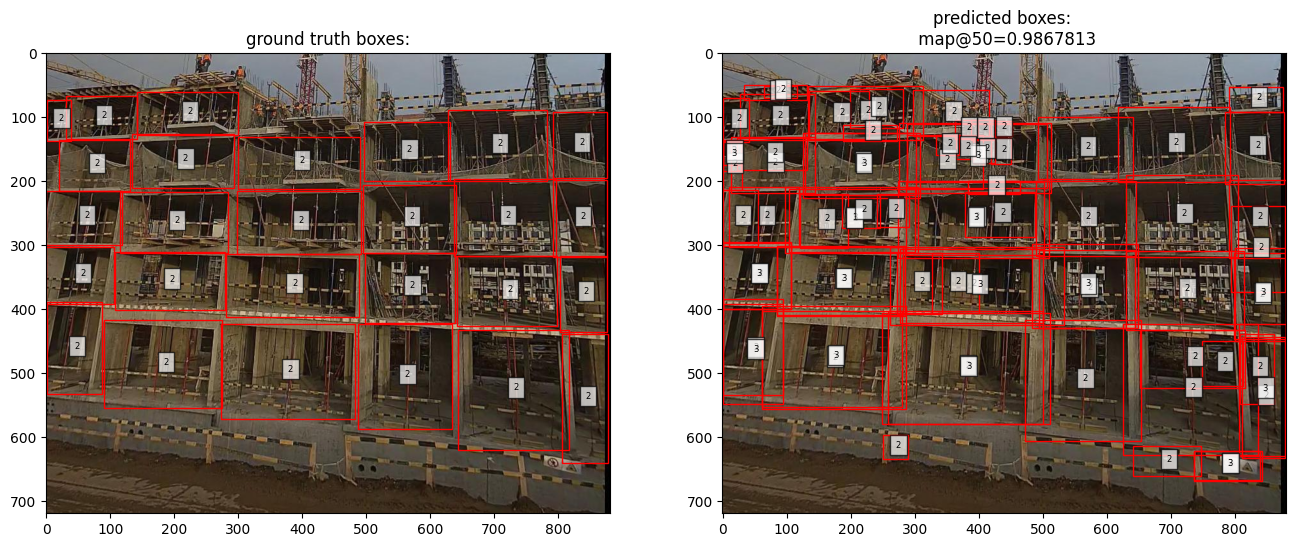

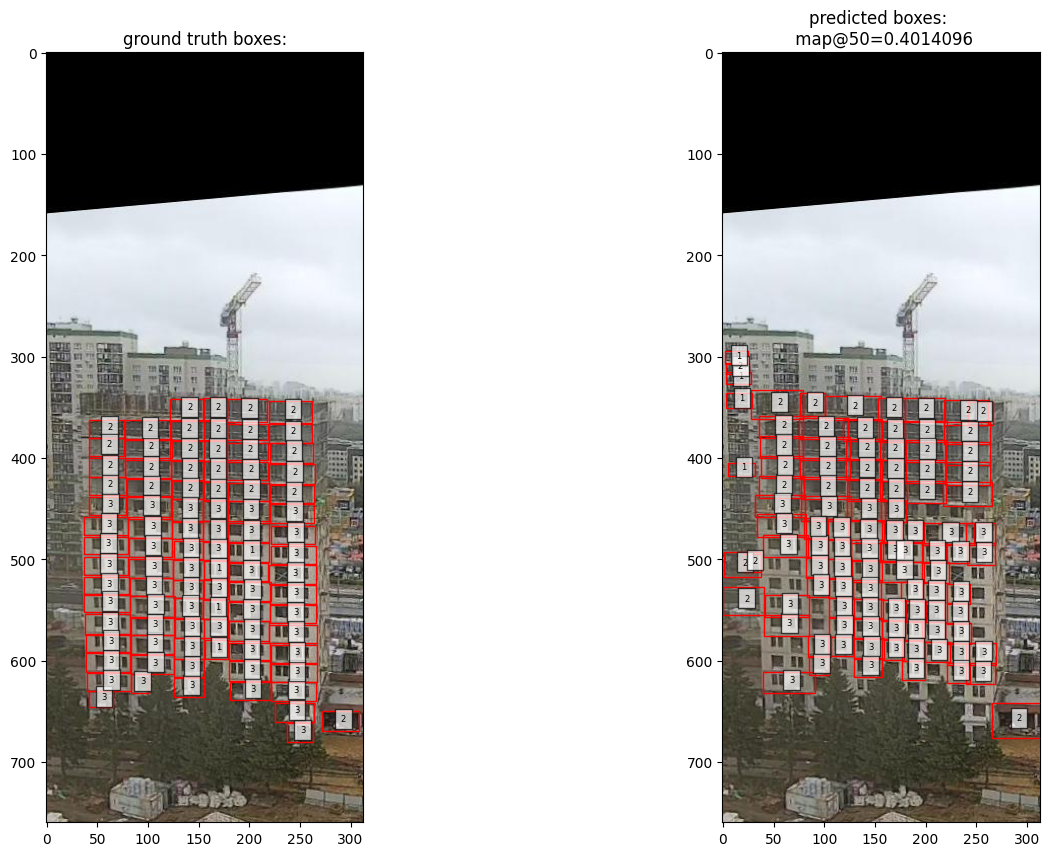

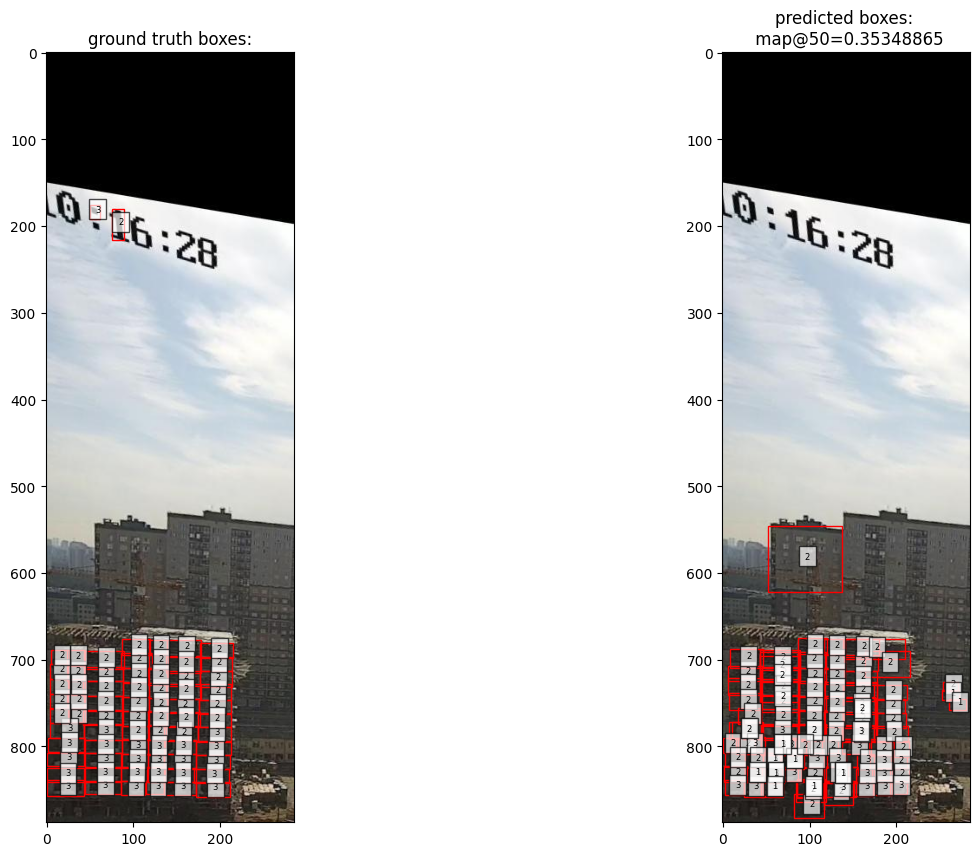

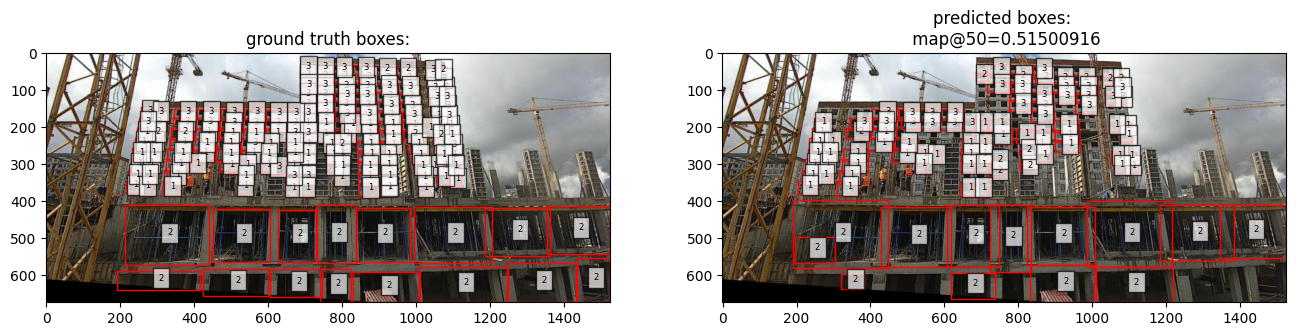

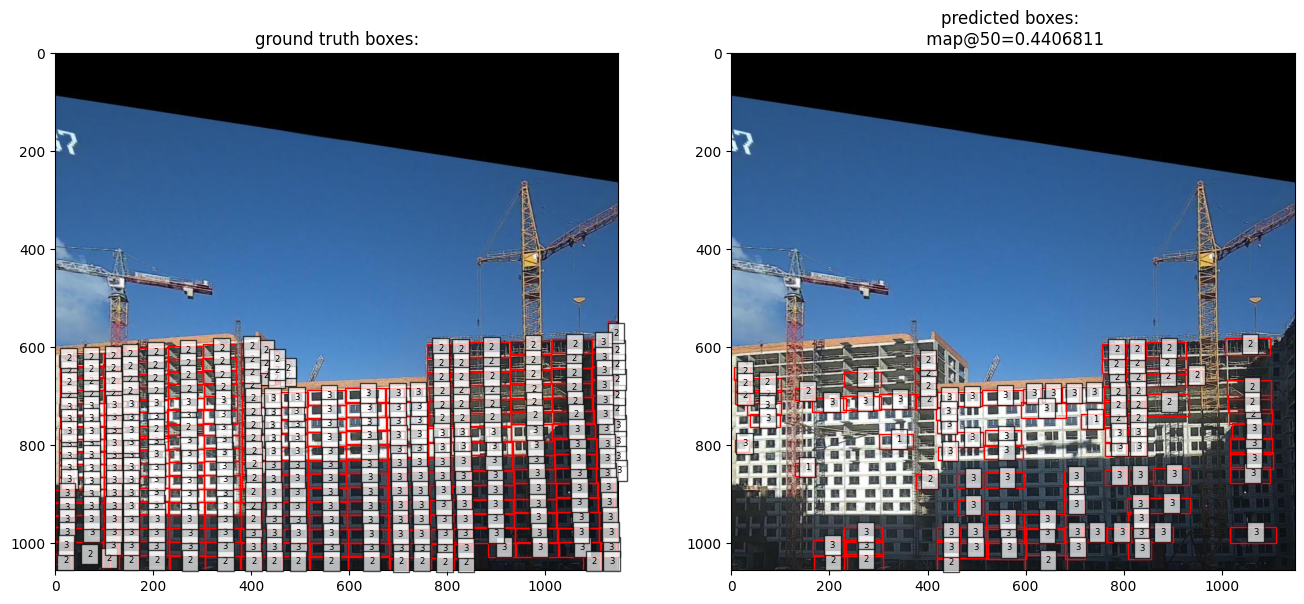

In [34]:
# For inference
model.eval()
iterator = iter(data_loader_test)
metric = MeanAveragePrecision(iou_type="bbox")

for i in range(5):
    x, target = next(iterator)
    predictions = model(x.to(device))
    pic = x[0].permute(1, 2, 0)
    gt_boxes = target[0]['boxes']
    pred_boxes = predictions[0]['boxes']#[predictions[0]['scores']>0.5]
    gt_labels = target[0]['labels']
    pred_labels = predictions[0]['labels']#[predictions[0]['scores']>0.5]

    ax = plot_boxes(pic, gt_boxes, pred_boxes, gt_labels, pred_labels)

    predictions_cpu = [{k:v.cpu().detach() for k,v in predictions[0].items()}]
    metric.update(predictions_cpu, target)
    metric_dict = metric.compute()
    ax[1].set_title('predicted boxes: \n map@50='+str(metric_dict['map_50'].cpu().detach().numpy()))
    plt.show()